In [2]:
# Import for basic packages

import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

In [4]:
# Setting random seed

np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
# Code for Google Drive import of video samples

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# View list of files

train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/val.csv').readlines())
batch_size = 8 

In [6]:
total_frames = 30
num_frames = 15 # Load 15 Frames
gestures = 5
image_height = 100 # Start with large size image
image_width = 100  # Start with large size image
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) # List image numbers you want to use for videos

In [7]:
from skimage.io import imread
from skimage.transform import resize
# Function to crop images

def resize_crop_image(image):
    if image.shape[0] > 120 and image.shape[1] > 120:
        image = resize(image, (120, 120))
        
    height = image.shape[0]
    width = image.shape[1]
    height_center = height//2
    width_center = width//2
    image = image[(height_center-60):(height_center+70), (width_center-50):(width_center+70)]
    image = resize(image,(image_height, image_width))
    return image

In [8]:
from matplotlib import pyplot as plt
# Function to show cropped images

def show_resize_crop_image(paths):

    for index, path in enumerate(paths):
        plt.figure(figsize=(20,20))
            
        plt.subplot(5, 2, index*2+1)
        image = resize_crop_image(imread(path))
        plt.imshow(image)
        plt.title('Modified')
        
        plt.subplot(5, 2, index*2+2)
        plt.imshow(imread(path))
        plt.title('Original')
                
    plt.show()

In [10]:
# Main Generator code here
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_crop_image(image)
                                         
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - np.percentile(image[:,:,0],5) / (np.percentile(image[:,:,0],95) - np.percentile(image[:,:,0],5)) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - np.percentile(image[:,:,1],5) / (np.percentile(image[:,:,1],95) - np.percentile(image[:,:,0],5))#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - np.percentile(image[:,:,2],5) / (np.percentile(image[:,:,2],95) - np.percentile(image[:,:,0],5))#normalise and feed in the image
                      
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            
            for batch in range(batch_size): # we iterate over the number of batches
                batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image = resize_crop_image(image)
                                         
                        batch_data[folder,idx,:,:,0] = image[:,:,0] - np.percentile(image[:,:,0],5) / (np.percentile(image[:,:,0],95) - np.percentile(image[:,:,0],5)) #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = image[:,:,1] - np.percentile(image[:,:,1],5) / (np.percentile(image[:,:,1],95) - np.percentile(image[:,:,0],5))#normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = image[:,:,2] - np.percentile(image[:,:,2],5) / (np.percentile(image[:,:,2],95) - np.percentile(image[:,:,0],5))#normalise and feed in the image
                   
                    
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, TimeDistributed, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

# Imports for models

# Experiment 1 - **Conv3D Standard**

In [13]:
# Standard Conv3D Model No additions
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))



In [14]:
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

# Using SGD Optimiser

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 100, 100, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 15, 100, 100, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 15, 100, 100, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 50, 50, 8)     0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 50, 50, 16)     3472      
                                                                 
 batch_normalization_1 (Batc  (None, 7, 50, 50, 16)    6

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [15]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [16]:
model_name = 'model_trial_1_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [18]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.7749 - categorical_accuracy: 0.2549 Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 8

Epoch 1: val_loss improved from inf to 1.60559, saving model to model_trial_1_init_2022-11-1610_36_12.198785/model-00001-1.77488-0.25490-1.60559-0.23000.h5
83/83 [==============================] - 2236s 27s/step - loss: 1.7749 - categorical_accuracy: 0.2549 - val_loss: 1.6056 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.5464 - categorical_accuracy: 0.2651
Epoch 2: val_loss improved from 1.60559 to 1.49942, saving model to model_trial_1_init_2022-11-1610_36_12.198785/model-00002-1.54642-0.26506-1.49942-0.25000.h5
83/83 [==============================] - 148s 2s/step - loss: 1.5464 - categorical_accuracy: 0.2651 - val_loss: 1.4994 - val_categorical_accuracy: 0.2500 - 

**Training Accuracy:** 0.37%

**Validation Accuracy:** 0.56%

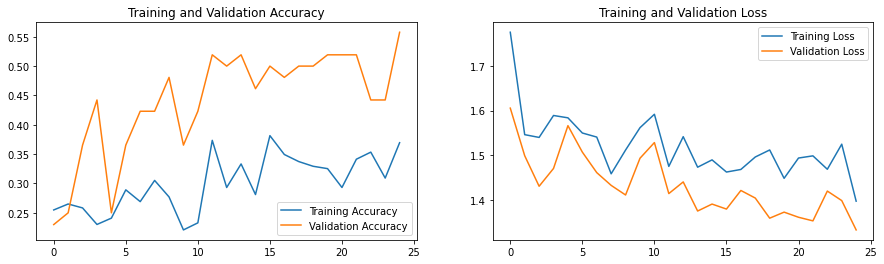

In [19]:
from IPython.display import Markdown, display
# Function to plot training history

def plot_history(history):
    display(Markdown("**Training Accuracy:** " + str(round(history.history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
    display(Markdown("**Validation Accuracy:** " + str(round(history.history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

# Experiment 2 - **Conv3D Lower Image Resolution**

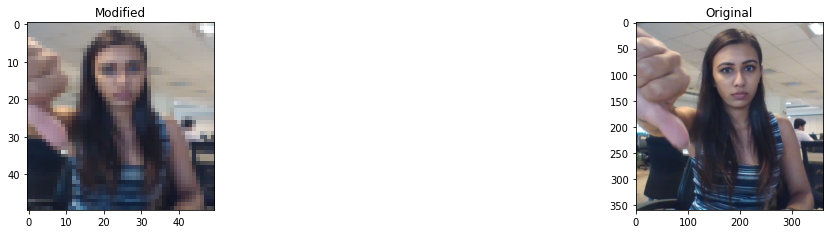

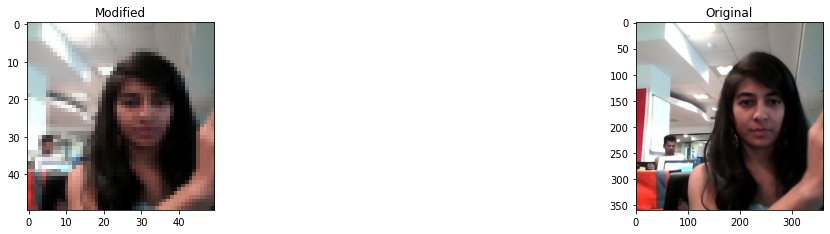

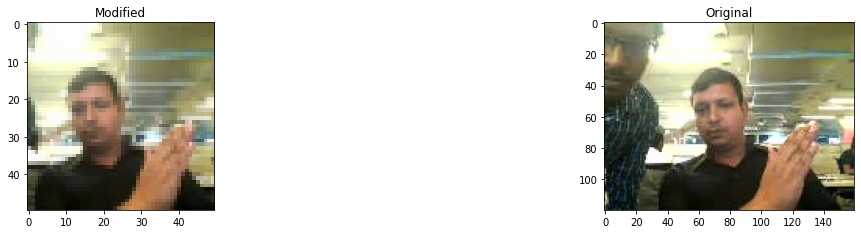

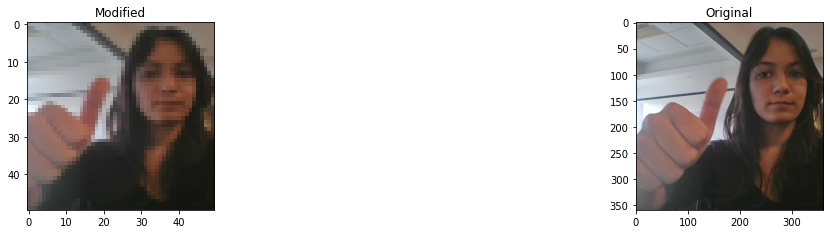

In [20]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

show_resize_crop_image(paths)

# This experiment will try to increase accuracy by lower resolution of input images

In [21]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

# Layers are very similar to thos used in experiment 1

In [22]:
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_3 (Batc  (None, 15, 50, 50, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 25, 25, 8)     0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_4 (Batc  (None, 7, 25, 25, 16)   

In [23]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [24]:
model_name = 'model_trial_2_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.9107 - categorical_accuracy: 0.2066Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 8

Epoch 1: val_loss improved from inf to 1.59040, saving model to model_trial_2_2022-11-1610_36_12.198785/model-00001-1.91065-0.20664-1.59040-0.24000.h5
83/83 [==============================] - 127s 2s/step - loss: 1.9107 - categorical_accuracy: 0.2066 - val_loss: 1.5904 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.5858 - categorical_accuracy: 0.2719
Epoch 2: val_loss improved from 1.59040 to 1.56038, saving model to model_trial_2_2022-11-1610_36_12.198785/model-00002-1.58583-0.27194-1.56038-0.21154.h5
83/83 [==============================] - 104s 1s/step - loss: 1.5858 - categorical_accuracy: 0.2719 - val_loss: 1.5604 - val_categorical_accuracy: 0.2115 - lr: 0.0010
Ep

**Training Accuracy:** 0.44%

**Validation Accuracy:** 0.52%

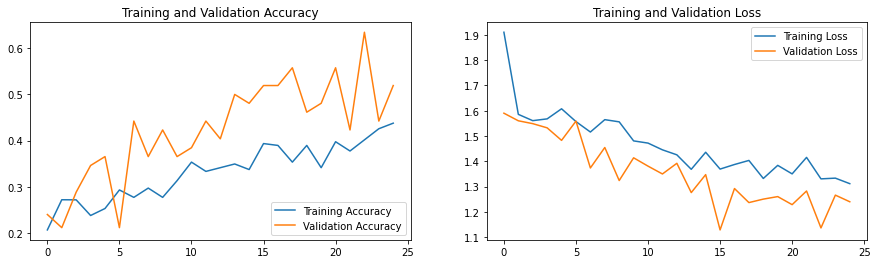

In [25]:
plot_history(history)

# Experiment 3 - **Conv3D Further Lower Image Resolution**

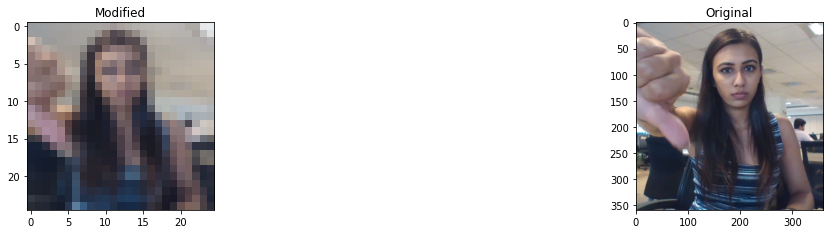

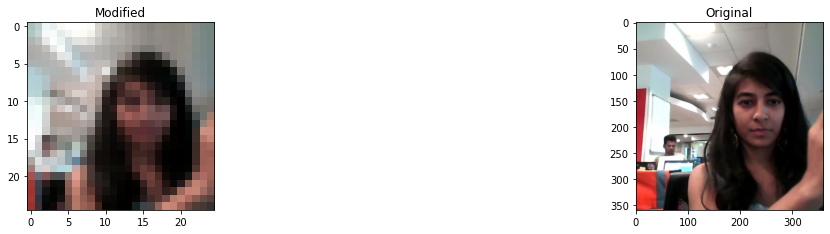

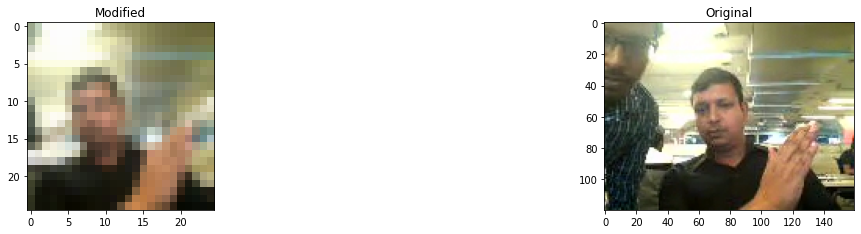

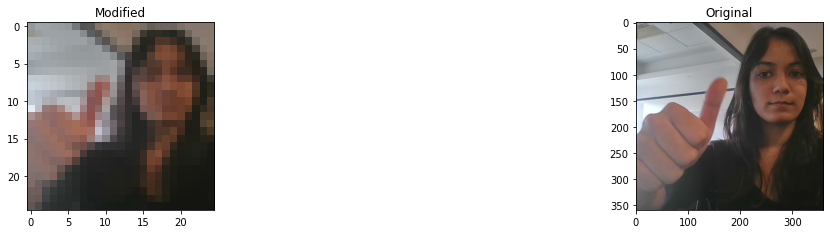

In [26]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 25
image_width = 25
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

show_resize_crop_image(paths)

# Further reducing image resolution via parameters that are fed to the generator

In [27]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [28]:
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 25, 25, 8)     656       
                                                                 
 batch_normalization_6 (Batc  (None, 15, 25, 25, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 15, 25, 25, 8)     0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 7, 12, 12, 8)     0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 7, 12, 12, 16)     3472      
                                                                 
 batch_normalization_7 (Batc  (None, 7, 12, 12, 16)   

In [29]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [30]:
model_name = 'model_trial_3_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.9632 - categorical_accuracy: 0.2081Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 8

Epoch 1: val_loss improved from inf to 1.62048, saving model to model_trial_3_2022-11-1610_36_12.198785/model-00001-1.96322-0.20814-1.62048-0.27000.h5
83/83 [==============================] - 124s 2s/step - loss: 1.9632 - categorical_accuracy: 0.2081 - val_loss: 1.6205 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.6150 - categorical_accuracy: 0.2754
Epoch 2: val_loss improved from 1.62048 to 1.47066, saving model to model_trial_3_2022-11-1610_36_12.198785/model-00002-1.61496-0.27539-1.47066-0.36538.h5
83/83 [==============================] - 105s 1s/step - loss: 1.6150 - categorical_accuracy: 0.2754 - val_loss: 1.4707 - val_categorical_accuracy: 0.3654 - lr: 0.0010
Ep

**Training Accuracy:** 0.39%

**Validation Accuracy:** 0.56%

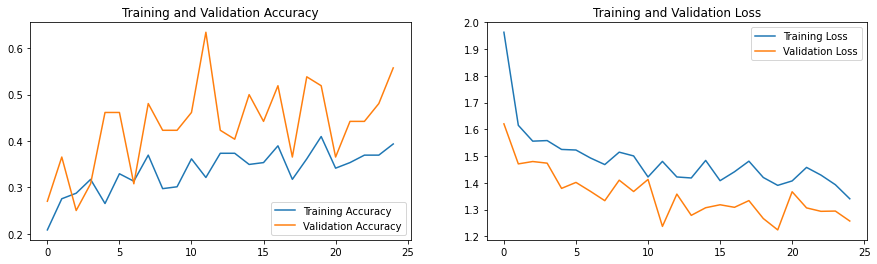

In [31]:
plot_history(history)

# Experiment 4 - **ConvLSTM Low Image Resolution**





In [43]:
model = Sequential()
# layer 1
model.add(TimeDistributed(Conv2D(8, (3,3), padding='same', strides=(2,2), activation='relu'),input_shape=(len(img_idx), image_height, image_width, 3)))
# layer 2
model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', strides=(2,2), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
# layer 3
model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', strides=(2,2), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Flatten()))

model.add(Dense(128, activation='relu'))

## using LSTM -> RNN model  and softmax -> last layer.
model.add(LSTM(128, return_sequences=False))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_11 (TimeDi  (None, 15, 13, 13, 8)    224       
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 15, 7, 7, 16)     1168      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 15, 3, 3, 16)     0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 2, 2, 32)     4640      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 1, 1, 32)    

In [44]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [45]:
model_name = 'model_trial_4_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.6168 - categorical_accuracy: 0.2247Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 8

Epoch 1: val_loss improved from inf to 1.63149, saving model to model_trial_4_2022-11-1610_36_12.198785/model-00001-1.61678-0.22474-1.63149-0.24000.h5
83/83 [==============================] - 127s 2s/step - loss: 1.6168 - categorical_accuracy: 0.2247 - val_loss: 1.6315 - val_categorical_accuracy: 0.2400 - lr: 7.8125e-06
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.6165 - categorical_accuracy: 0.2238
Epoch 2: val_loss improved from 1.63149 to 1.62862, saving model to model_trial_4_2022-11-1610_36_12.198785/model-00002-1.61654-0.22375-1.62862-0.17308.h5
83/83 [==============================] - 103s 1s/step - loss: 1.6165 - categorical_accuracy: 0.2238 - val_loss: 1.6286 - val_categorical_accuracy: 0.1731 - lr: 7.812

**Training Accuracy:** 0.26%

**Validation Accuracy:** 0.19%

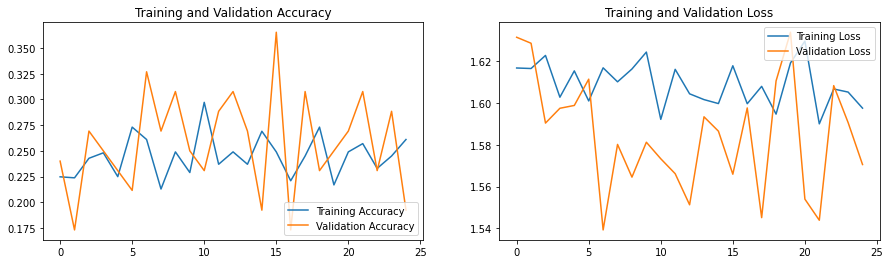

In [46]:
plot_history(history)

# Experiment 5 - **Adam Optimiser**

In [47]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs=25

img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

# Image resolution oges back to 50 after seeing no benefit in reducing further

In [48]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
# We change the optimiser to Adam from SGD on the line above
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_11 (Bat  (None, 15, 50, 50, 8)    32        
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 25, 25, 8)     0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_12 (Bat  (None, 7, 25, 25, 16)  

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [50]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [51]:
model_name = 'model_trial5_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [52]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.8030 - categorical_accuracy: 0.2202Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.50228, saving model to model_exp5_2022-11-1610_36_12.198785/model-00001-1.80301-0.22021-1.50228-0.31000.h5
166/166 [==============================] - 130s 778ms/step - loss: 1.8030 - categorical_accuracy: 0.2202 - val_loss: 1.5023 - val_categorical_accuracy: 0.3100 - lr: 2.0000e-04
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.5991 - categorical_accuracy: 0.2651
Epoch 2: val_loss improved from 1.50228 to 1.49381, saving model to model_exp5_2022-11-1610_36_12.198785/model-00002-1.59912-0.26506-1.49381-0.39000.h5
166/166 [==============================] - 101s 610ms/step - loss: 1.5991 - categorical_accuracy: 0.2651 - val_loss: 1.4938 - val_categorical_accuracy: 0.3900 - l

**Training Accuracy:** 0.54%

**Validation Accuracy:** 0.7%

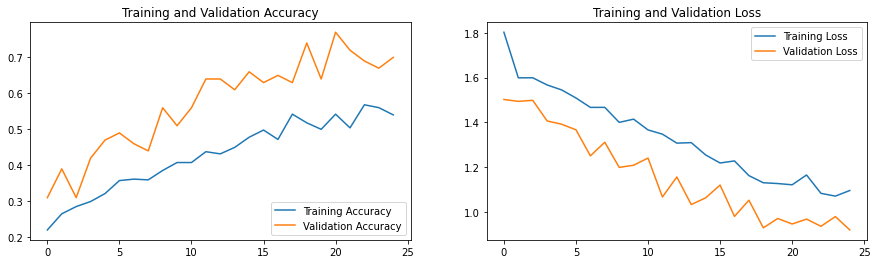

In [53]:
plot_history(history)

# Experiment 6 - **ADAM Optimiser with batch size 8**

In [55]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 8
num_epochs= 25

img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

# We now increase batch size to see if we can further improve the model output

In [56]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_14 (Bat  (None, 15, 50, 50, 8)    32        
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 7, 25, 25, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_15 (Bat  (None, 7, 25, 25, 16)  

In [57]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [58]:
model_name = 'model_trial6_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [59]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.8403 - categorical_accuracy: 0.2157Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 8

Epoch 1: val_loss improved from inf to 1.58861, saving model to model_exp6_2022-11-1610_36_12.198785/model-00001-1.84032-0.21569-1.58861-0.20000.h5
83/83 [==============================] - 129s 2s/step - loss: 1.8403 - categorical_accuracy: 0.2157 - val_loss: 1.5886 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.6166 - categorical_accuracy: 0.2513
Epoch 2: val_loss improved from 1.58861 to 1.57507, saving model to model_exp6_2022-11-1610_36_12.198785/model-00002-1.61663-0.25129-1.57507-0.28846.h5
83/83 [==============================] - 106s 1s/step - loss: 1.6166 - categorical_accuracy: 0.2513 - val_loss: 1.5751 - val_categorical_accuracy: 0.2885 - lr: 2.0000e-04


**Training Accuracy:** 0.42%

**Validation Accuracy:** 0.6%

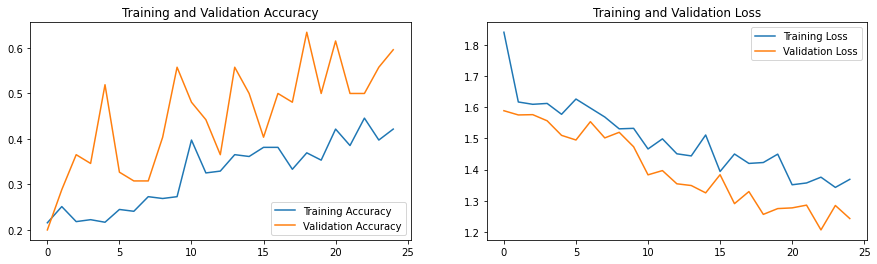

In [60]:
plot_history(history)

### Experiment 7 - **Reduce Dropout and Frames Used**

In [61]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
# Reduce dropout and frames to increase accuracy and fitting issues, batch is back to 4
num_epochs=25

In [62]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_17 (Bat  (None, 10, 50, 50, 8)    32        
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 5, 25, 25, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_16 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_18 (Bat  (None, 5, 25, 25, 16)  

In [63]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [64]:
model_name = 'model_trial7_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [65]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.6675 - categorical_accuracy: 0.2383Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.54597, saving model to model_exp7_2022-11-1610_36_12.198785/model-00001-1.66745-0.23831-1.54597-0.26000.h5
166/166 [==============================] - 826s 5s/step - loss: 1.6675 - categorical_accuracy: 0.2383 - val_loss: 1.5460 - val_categorical_accuracy: 0.2600 - lr: 2.0000e-04
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.5139 - categorical_accuracy: 0.3353
Epoch 2: val_loss improved from 1.54597 to 1.47877, saving model to model_exp7_2022-11-1610_36_12.198785/model-00002-1.51385-0.33534-1.47877-0.43000.h5
166/166 [==============================] - 72s 435ms/step - loss: 1.5139 - categorical_accuracy: 0.3353 - val_loss: 1.4788 - val_categorical_accuracy: 0.4300 - lr: 2

**Training Accuracy:** 0.87%

**Validation Accuracy:** 0.76%

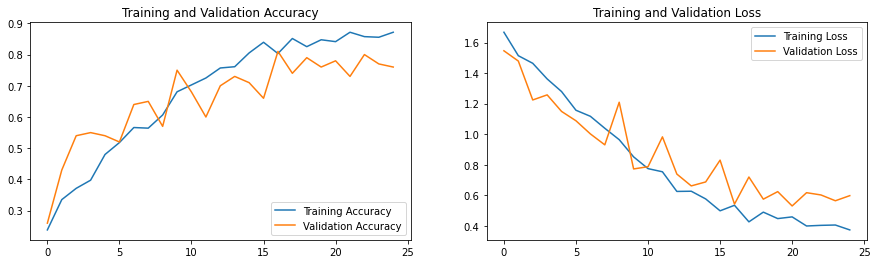

In [66]:
plot_history(history)

# Experiment 8 - **Increase in Epochs**

In [68]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs=30

In [70]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_23 (Bat  (None, 10, 50, 50, 8)    32        
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 5, 25, 25, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_22 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_24 (Bat  (None, 5, 25, 25, 16)  

In [71]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [72]:
model_name = 'model_trial8_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]



In [73]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 4
Epoch 1/30
166/166 [==============================] - ETA: 0s - loss: 1.6696 - categorical_accuracy: 0.2670Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.53081, saving model to model_trial8_2022-11-1610_36_12.198785/model-00001-1.66960-0.26697-1.53081-0.24000.h5
166/166 [==============================] - 89s 533ms/step - loss: 1.6696 - categorical_accuracy: 0.2670 - val_loss: 1.5308 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 2/30
166/166 [==============================] - ETA: 0s - loss: 1.5090 - categorical_accuracy: 0.3454
Epoch 2: val_loss improved from 1.53081 to 1.35743, saving model to model_trial8_2022-11-1610_36_12.198785/model-00002-1.50902-0.34538-1.35743-0.42000.h5
166/166 [==============================] - 68s 414ms/step - loss: 1.5090 - categorical_accuracy: 0.3454 - val_loss: 1.3574 - val_categorical_accuracy: 0.4200 -

**Training Accuracy:** 0.81%

**Validation Accuracy:** 0.7%

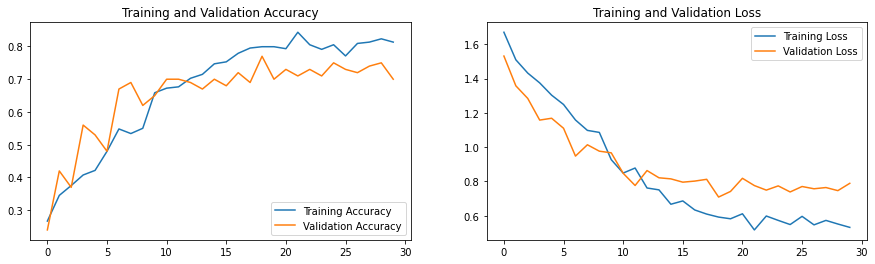

In [74]:
plot_history(history)

# Experiment 9 - **ConvLSTM with ADAM**

In [76]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs=25

In [77]:
model = Sequential()
# layer 1
model.add(TimeDistributed(Conv2D(8, (3,3), padding='same', strides=(2,2), activation='relu'),input_shape=(len(img_idx), image_height, image_width, 3)))
# layer 2
model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', strides=(2,2), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
# layer 3
model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', strides=(2,2), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Flatten()))

model.add(Dense(128, activation='relu'))

## using LSTM -> RNN model  and softmax -> last layer.
model.add(LSTM(128, return_sequences=False))
model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_25 (TimeDi  (None, 10, 25, 25, 8)    224       
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 10, 13, 13, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 10, 6, 6, 16)     0         
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 10, 3, 3, 32)     4640      
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 10, 1, 1, 32)   

In [78]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [79]:
model_name = 'model_trial9_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [80]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.5248 - categorical_accuracy: 0.3183Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.62942, saving model to model_trial9_2022-11-1610_36_12.198785/model-00001-1.52484-0.31825-1.62942-0.30000.h5
166/166 [==============================] - 91s 534ms/step - loss: 1.5248 - categorical_accuracy: 0.3183 - val_loss: 1.6294 - val_categorical_accuracy: 0.3000 - lr: 2.0000e-04
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.4319 - categorical_accuracy: 0.3675
Epoch 2: val_loss improved from 1.62942 to 1.33608, saving model to model_trial9_2022-11-1610_36_12.198785/model-00002-1.43189-0.36747-1.33608-0.44000.h5
166/166 [==============================] - 72s 435ms/step - loss: 1.4319 - categorical_accuracy: 0.3675 - val_loss: 1.3361 - val_categorical_accuracy: 0.4400 -

**Training Accuracy:** 0.62%

**Validation Accuracy:** 0.49%

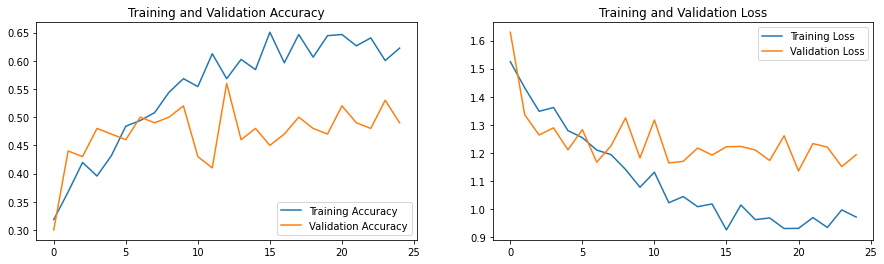

In [81]:
plot_history(history)